### Forecast Revisions with TimeDB

This notebook demonstrates how to work with overlapping forecast revisions in TimeDB.

#### What you'll learn:
1. **Creating overlapping forecasts** - Multiple forecasts for the same series with different known_time
2. **Reading all forecast revisions** - Querying all versions of forecasts with a single query
3. **Visualizing forecast revisions** - Plotting overlapping forecasts to see how they evolve

**Key Concepts:**
- `known_time`: When the forecast was made (run_start_time)
- `valid_time`: The time period the forecast predicts
- Overlapping forecasts: Multiple forecasts made at different times predicting the same future periods


In [16]:
import timedb as td
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import time
import numpy as np

# Load environment variables (for database connection)
from dotenv import load_dotenv
load_dotenv()

print("✓ Imports successful")

✓ Imports successful


## Part 1: Create Database Schema and Prepare for Forecasts


In [17]:
# Create database schema
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


## Part 2: Create 4 Forecasts with Shifting Valid Times

We'll create 4 forecasts in a loop, where each forecast's `valid_time` range starts at its `known_time`. The `run_start_time` will default to the current time when the script runs. All forecasts:
- Predict the same series (series_key="power")
- Have a 3-day horizon with hourly resolution (72 hours)
- Have `known_time` set 1 day apart
- Each forecast's `valid_time` starts at its `known_time`, so later forecasts are shifted forward in time


In [18]:
# Base time for first forecast
base_valid_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)

# Forecast horizon: 3 days with hourly resolution
forecast_horizon_hours = 72

# Number of forecasts to create
num_forecasts = 4

# Store forecast metadata
forecast_metadata = []

print(f"Creating {num_forecasts} forecasts...")
print(f"Forecast horizon: {forecast_horizon_hours} hours (3 days)")
print(f"Each forecast's valid_time starts at its known_time")
print()

for i in range(num_forecasts):
    # Each forecast's known_time is 1 day apart, starting from base_valid_time
    known_time = base_valid_time + timedelta(days=i)
    
    # Each forecast's valid_time range starts at its known_time
    # Generate valid_time range (3 days, hourly) starting from known_time
    valid_times = [known_time + timedelta(hours=j) for j in range(forecast_horizon_hours)]
    
    # Generate forecast values: sinus function base + random walk error
    # This makes forecasts look realistic - following a pattern with small forecast errors
    
    # Base sinus function parameters
    base_power = 100.0  # Mean power level
    amplitude = 30.0     # Amplitude of sinus function (daily pattern)
    period_hours = 24    # Period of sinus (24 hours for daily pattern)
    
    # Generate sinus function for the base pattern
    # Use hours from start of valid_time range as x-axis
    hours_from_start = np.arange(forecast_horizon_hours)
    sinus_base = base_power + amplitude * np.sin(2 * np.pi * hours_from_start / period_hours)
    
    # Add random walk error - small relative to sinus amplitude
    # Error represents forecast uncertainty that accumulates over time
    np.random.seed(42 + i)  # Different seed for each forecast for reproducibility
    error_std = amplitude * 0.03  # Error std is 1% of sinus amplitude (small relative to pattern)
    error_steps = np.random.normal(0, error_std, forecast_horizon_hours)
    error_walk = np.cumsum(error_steps)
    
    # Combine sinus base with error walk
    forecast_values = sinus_base + error_walk
    forecast_values = np.round(forecast_values, 2).tolist()
    
    # Create DataFrame (no units for simplicity)
    df_forecast = pd.DataFrame({
        "valid_time": valid_times,
        "power": forecast_values
    })
    
    # Insert forecast - run_start_time defaults to current time
    # known_time is the start of this forecast's valid_time range
    result = td.insert_run(
        df=df_forecast,
        known_time=known_time,  # known_time is the start of valid_time for this forecast
        series_key_overrides={"power": "forecast"}  # Use "forecast" as series_key
    )
    
    forecast_metadata.append({
        "forecast_num": i + 1,
        "known_time": known_time,
        "valid_time_start": valid_times[0],
        "valid_time_end": valid_times[-1],
        "run_id": result.run_id,
        "series_id": result.series_ids["forecast"]
    })
    
    print(f"✓ Forecast {i+1}/{num_forecasts} created")
    print(f"  known_time: {known_time}")
    print(f"  valid_time range: {valid_times[0]} to {valid_times[-1]}")
    print(f"  Run ID: {result.run_id}")
    print()

print(f"✓ All {num_forecasts} forecasts created successfully!")

# Now insert the true sinus function as "actual" (flat time series without revisions)
print("\n" + "=" * 60)
print("Inserting actual values (true sinus function)...")
print("=" * 60)

# Calculate the overall valid_time range covering all forecasts
# We'll insert actual values for the entire range
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(days=num_forecasts - 1) + timedelta(hours=forecast_horizon_hours)

# Generate all valid_times for the actual series
actual_valid_times = []
current_time = start_valid
while current_time < end_valid:
    actual_valid_times.append(current_time)
    current_time += timedelta(hours=1)

# Generate actual values using the true sinus function (no error)
base_power = 100.0
amplitude = 30.0
period_hours = 24

hours_from_start = np.arange(len(actual_valid_times))
actual_values = base_power + amplitude * np.sin(2 * np.pi * hours_from_start / period_hours)
actual_values = np.round(actual_values, 2).tolist()

# Create DataFrame for actual values
df_actual = pd.DataFrame({
    "valid_time": actual_valid_times,
    "power": actual_values
})

# Insert actual values with known_time set to the last valid_time
# This represents when the actual values become known (after all data is collected)
actual_known_time = actual_valid_times[-1]
result_actual = td.insert_run(
    df=df_actual,
    known_time=actual_known_time,  # Set known_time to the last valid_time
    series_key_overrides={"power": "actual"}  # Use "actual" as series_key
)

print(f"✓ Actual values inserted successfully!")
print(f"  Series key: actual")
print(f"  Valid time range: {actual_valid_times[0]} to {actual_valid_times[-1]}")
print(f"  Number of data points: {len(actual_valid_times)}")
print(f"  Run ID: {result_actual.run_id}")
print(f"\nAll forecasts predict the same series: forecast")
print(f"Actual values are stored in series: actual")
print(f"Each forecast's valid_time starts at its known_time, shifted forward by 1 day for each subsequent forecast")


Creating 4 forecasts...
Forecast horizon: 72 hours (3 days)
Each forecast's valid_time starts at its known_time

Data values inserted successfully.
✓ Forecast 1/4 created
  known_time: 2025-01-01 00:00:00+00:00
  valid_time range: 2025-01-01 00:00:00+00:00 to 2025-01-03 23:00:00+00:00
  Run ID: 7e873695-9ddf-4f4b-b808-a9305e8612ab

Data values inserted successfully.
✓ Forecast 2/4 created
  known_time: 2025-01-02 00:00:00+00:00
  valid_time range: 2025-01-02 00:00:00+00:00 to 2025-01-04 23:00:00+00:00
  Run ID: 8b5efb2c-1f0d-498c-91c7-3e53bdaa177c

Data values inserted successfully.
✓ Forecast 3/4 created
  known_time: 2025-01-03 00:00:00+00:00
  valid_time range: 2025-01-03 00:00:00+00:00 to 2025-01-05 23:00:00+00:00
  Run ID: 761210e5-66ad-4267-9379-00bb0c99c6d5

Data values inserted successfully.
✓ Forecast 4/4 created
  known_time: 2025-01-04 00:00:00+00:00
  valid_time range: 2025-01-04 00:00:00+00:00 to 2025-01-06 23:00:00+00:00
  Run ID: 98d86f0b-4e0c-4457-a9e5-5cbdf832f561

✓ A

## Part 3: Read All Forecast Revisions

Now we'll read back all forecast revisions using the `overlapping` mode from `db.read.read_values_between`.
This returns all forecasts with both `known_time` and `valid_time` in a single query.


In [19]:
# Read latest forecast values (flat mode)
# This returns the most recent forecast for each valid_time based on known_time

# Calculate the overall valid_time range covering all forecasts
# First forecast starts at base_valid_time, last forecast ends at base_valid_time + (num_forecasts-1) days + forecast_horizon_hours
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(days=num_forecasts - 1) + timedelta(hours=forecast_horizon_hours)

df_flat = td.read_values_flat(
    start_valid=start_valid,
    end_valid=end_valid
)

print(f"✓ Read {len(df_flat)} forecast data points")
print(f"DataFrame shape: {df_flat.shape}")
print(f"Index: {df_flat.index.name}")
print(f"Columns: {list(df_flat.columns)}")
print(f"\nThis shows the latest forecast values for each valid_time.")
print(f"\nFirst few rows:")
df_flat.head(10)


✓ Read 144 forecast data points
DataFrame shape: (144, 2)
Index: valid_time
Columns: ['forecast', 'actual']

This shows the latest forecast values for each valid_time.

First few rows:


series_key,forecast,actual
valid_time,,
2025-01-01 00:00:00+00:00,100.45,100.00
2025-01-01 01:00:00+00:00,108.09,107.76
2025-01-01 02:00:00+00:00,115.91,115.00
2025-01-01 03:00:00+00:00,123.49,121.21
2025-01-01 04:00:00+00:00,128.05,125.98
2025-01-01 05:00:00+00:00,130.83,128.98
2025-01-01 06:00:00+00:00,133.28,130.00
2025-01-01 07:00:00+00:00,132.94,128.98
2025-01-01 08:00:00+00:00,129.53,125.98


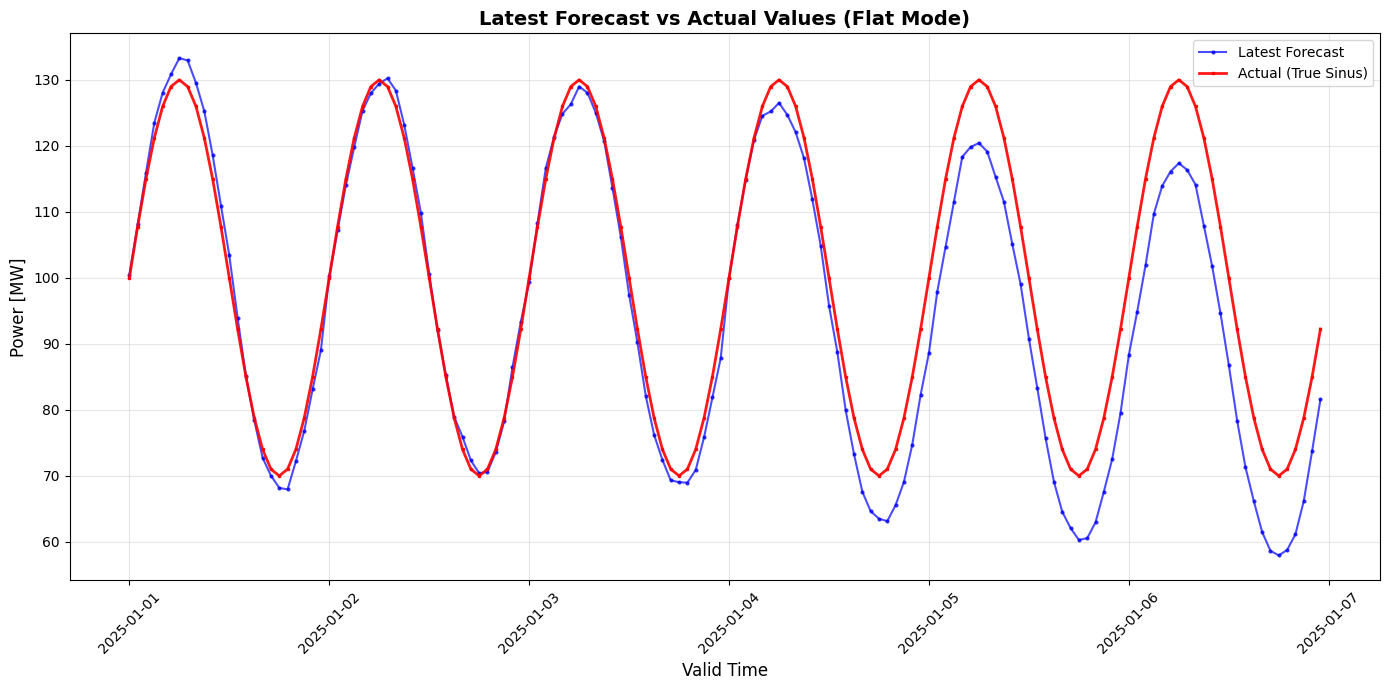

✓ Latest forecast and actual values plotted successfully!


In [20]:
# Plot the latest forecast and actual values (flat mode)
plt.figure(figsize=(14, 7))

# Plot forecast and actual
plt.plot(df_flat.index, df_flat['forecast'], marker='o', markersize=2, linewidth=1.5, 
         label='Latest Forecast', alpha=0.7, color='blue')
plt.plot(df_flat.index, df_flat['actual'], marker='s', markersize=2, linewidth=2, 
         label='Actual (True Sinus)', alpha=0.9, color='red')

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('Power [MW]', fontsize=12)
plt.title('Latest Forecast vs Actual Values (Flat Mode)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ Latest forecast and actual values plotted successfully!")


## Part 4: Read All Forecast Revisions (Overlapping Mode)

Now let's read all forecast revisions using `td.read_values_overlapping()`.
This returns all forecasts with both `known_time` and `valid_time`, showing how
forecasts evolve over time. This is useful for analyzing forecast revisions and backtesting.


In [21]:
# Read all forecast revisions (overlapping mode)
print("Reading all forecast revisions (overlapping mode)...")
print("=" * 60)

# Calculate the overall valid_time range covering all forecasts
# First forecast starts at base_valid_time, last forecast ends at base_valid_time + (num_forecasts-1) days + forecast_horizon_hours
start_valid = base_valid_time
end_valid = base_valid_time + timedelta(days=num_forecasts - 1) + timedelta(hours=forecast_horizon_hours)

df_overlapping = td.read_values_overlapping(
    start_valid=start_valid,
    end_valid=end_valid
)

print(f"✓ Read {len(df_overlapping)} forecast data points")
print(f"\nDataFrame shape: {df_overlapping.shape}")
print(f"\nIndex levels: {df_overlapping.index.names}")
print(f"\nColumns: {list(df_overlapping.columns)}")
print(f"\nThis shows all forecast revisions, including all known_time values.")
print(f"\nFirst few rows:")
df_overlapping.head(10)

Reading all forecast revisions (overlapping mode)...
✓ Read 432 forecast data points

DataFrame shape: (432, 2)

Index levels: ['known_time', 'valid_time']

Columns: ['forecast', 'actual']

This shows all forecast revisions, including all known_time values.

First few rows:


series_key                                           forecast  actual
known_time                valid_time                                 
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00    100.45     NaN
                          2025-01-01 01:00:00+00:00    108.09     NaN
                          2025-01-01 02:00:00+00:00    115.91     NaN
                          2025-01-01 03:00:00+00:00    123.49     NaN
                          2025-01-01 04:00:00+00:00    128.05     NaN
                          2025-01-01 05:00:00+00:00    130.83     NaN
                          2025-01-01 06:00:00+00:00    133.28     NaN
                          2025-01-01 07:00:00+00:00    132.94     NaN
                          2025-01-01 08:00:00+00:00    129.53     NaN
                          2025-01-01 09:00:00+00:00    125.25     NaN

Plotting 4 forecast revisions...


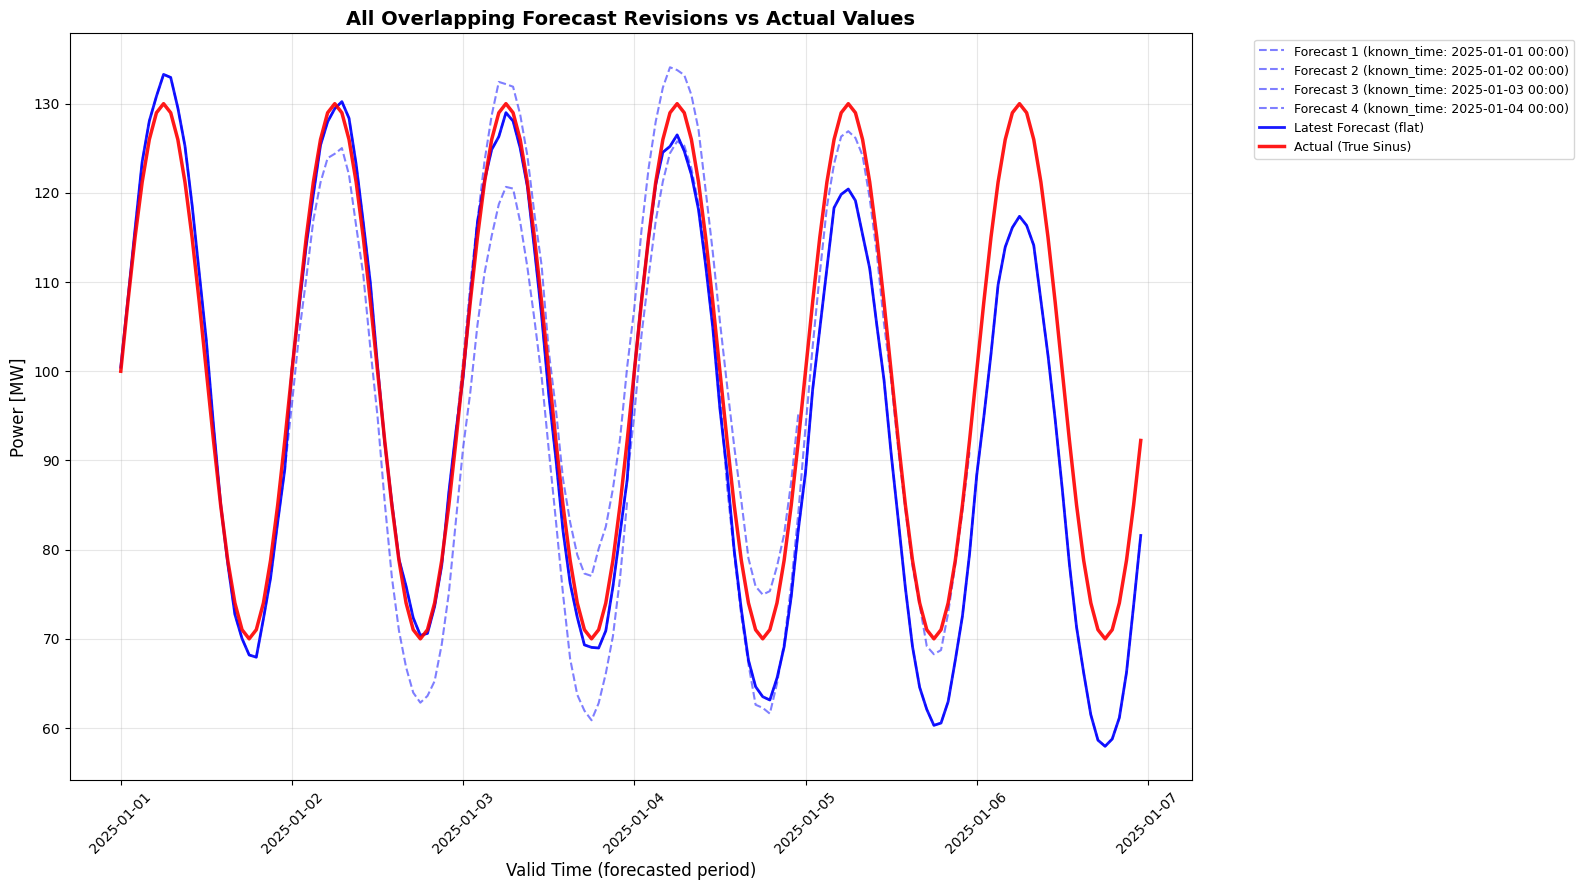

✓ All forecast revisions and actual values plotted successfully!


In [22]:
# Plot all overlapping forecasts and actual values
plt.figure(figsize=(16, 9))

# Separate forecast and actual data
df_forecast_overlapping = df_overlapping[['forecast']].dropna()
df_actual_overlapping = df_overlapping[['actual']].dropna()

# Get unique known_times from the forecast series only (exclude actual's known_time)
# Each known_time in the forecast series represents a different forecast revision
unique_known_times = df_forecast_overlapping.index.get_level_values("known_time").unique()
unique_known_times = sorted(unique_known_times)

print(f"Plotting {len(unique_known_times)} forecast revisions...")

# Plot each forecast revision with dashed blue lines
for idx, known_time in enumerate(unique_known_times):
    # Get all values for this known_time
    forecast_data = df_forecast_overlapping.xs(known_time, level="known_time")
    
    # Extract valid_time and values
    valid_times_plot = forecast_data.index
    values = forecast_data['forecast'].values
    
    # Plot this forecast revision with dashed blue line
    label = f"Forecast {idx+1} (known_time: {known_time.strftime('%Y-%m-%d %H:%M')})"
    plt.plot(valid_times_plot, values, linewidth=1.5, linestyle='--', 
            label=label, color='blue', alpha=0.5)

# Plot the latest forecast from flat data (read_values_flat) with solid blue line
plt.plot(df_flat.index, df_flat['forecast'], linewidth=2, linestyle='-', 
        label='Latest Forecast (flat)', color='blue', alpha=0.9, zorder=5)

# Plot actual values
# Actual values will have the same known_time (when they were inserted)
# Get unique valid_times and actual values (they should be the same across known_times)
actual_data = df_actual_overlapping.reset_index()
# Group by valid_time and take the first value (they should all be the same)
actual_data = actual_data.groupby('valid_time')['actual'].first().sort_index()

plt.plot(actual_data.index, actual_data.values, 
        linewidth=2.5, label='Actual (True Sinus)', alpha=0.9, color='red', zorder=10)

# Formatting
plt.xlabel('Valid Time (forecasted period)', fontsize=12)
plt.ylabel('Power [MW]', fontsize=12)
plt.title('All Overlapping Forecast Revisions vs Actual Values', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✓ All forecast revisions and actual values plotted successfully!")


In [23]:
# The DataFrame from read_values_overlapping already has the correct structure:
# - Index: (known_time, valid_time) - double index
# - Columns: series_key (in this case "power")
# No reshaping needed!

df_forecast_revisions = df_overlapping

print(f"✓ DataFrame with (known_time, valid_time) index and '{list(df_forecast_revisions.columns)[0]}' column")
print(f"\nDataFrame shape: {df_forecast_revisions.shape}")
print(f"\nIndex levels: {df_forecast_revisions.index.names}")
print(f"\nColumn: {list(df_forecast_revisions.columns)}")
print(f"\nFirst few rows:")
df_forecast_revisions.head(15)


✓ DataFrame with (known_time, valid_time) index and 'forecast' column

DataFrame shape: (432, 2)

Index levels: ['known_time', 'valid_time']

Column: ['forecast', 'actual']

First few rows:


series_key                                           forecast  actual
known_time                valid_time                                 
2025-01-01 00:00:00+00:00 2025-01-01 00:00:00+00:00    100.45     NaN
                          2025-01-01 01:00:00+00:00    108.09     NaN
                          2025-01-01 02:00:00+00:00    115.91     NaN
                          2025-01-01 03:00:00+00:00    123.49     NaN
                          2025-01-01 04:00:00+00:00    128.05     NaN
                          2025-01-01 05:00:00+00:00    130.83     NaN
                          2025-01-01 06:00:00+00:00    133.28     NaN
                          2025-01-01 07:00:00+00:00    132.94     NaN
                          2025-01-01 08:00:00+00:00    129.53     NaN
                          2025-01-01 09:00:00+00:00    125.25     NaN
                          2025-01-01 10:00:00+00:00    118.62     NaN
                          2025-01-01 11:00:00+00:00    110.96     NaN
                          2025-01-01 12:00:00+00:00    103.41     NaN
                          2025-01-01 13:00:00+00:00     93.93     NaN
                          2025-01-01 14:00:00+00:00     85.14     NaN

## Summary

This notebook demonstrated:

1. **Creating overlapping forecasts**: Multiple forecasts for the same series with different `known_time` values
2. **Reading latest values**: Using `td.read_values_flat()` to get the most recent forecast for each valid_time
3. **Reading all revisions**: Using `td.read_values_overlapping()` to get all forecast versions

**Key Takeaways:**
- `known_time` represents when the forecast was made (run_start_time)
- `valid_time` represents the time period being forecasted
- `read_values_flat()` returns the latest forecast values (one per valid_time) with `series_key` as columns
- `read_values_overlapping()` returns all forecast revisions with index `(known_time, valid_time)` and `series_key` as columns
- Overlapping forecasts allow you to track how predictions change as new information becomes available
